In [14]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Loading the Dataset

In [15]:
file_path = '../input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'

names = ['class']
names.extend([i for i in range(1, 785)])

df = pd.read_csv(file_path, header=None, names=names)

y_full = df['class']
x_full = df.drop('class', axis=1).values.reshape(-1, 28, 28, 1)

# Splitting Dataset

In [16]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(x_full, y_full):
    x_train_full, y_train_full = x_full[train_idx], y_full.iloc[train_idx].values
    x_test, y_test = x_full[test_idx], y_full.iloc[test_idx].values

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.1,
    stratify=y_train_full,
    random_state=42
)

# Data Augmentation

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.20,
    rescale=1./255
)

In [18]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [19]:
train_loader = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

In [20]:
valid_loader = valid_datagen.flow(
    x_valid, y_valid,
    batch_size=32,
    shuffle=False
)

In [21]:
test_loader = test_datagen.flow(
    x_test, y_test,
    batch_size=32,
    shuffle=False
)

# Building the pretrained MobileNet

In [22]:
def build_mobilenet(input_shape=(64,64,1), num_classes=26):
    model = models.Sequential()
    
    # Initial Conv layer (standard conv)
    model.add(layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    
    # Helper function for depthwise + pointwise block
    def dw_pw_block(out_channels, stride=1):
        block = models.Sequential()
        # Depthwise conv
        block.add(layers.DepthwiseConv2D((3,3), strides=stride, padding='same'))
        block.add(layers.BatchNormalization())
        block.add(layers.ReLU())
        # Pointwise conv (1x1)
        block.add(layers.Conv2D(out_channels, (1,1), padding='same', activation='relu'))
        block.add(layers.BatchNormalization())
        return block
    
    # Blocks configuration: (output_channels, stride)
    blocks = [
        (64, 1),
        (128, 2),
        (128, 1),
        (256, 2),
        (256, 1),
        (512, 2),
        (512, 1),
        (512, 1),
        (512, 1),
        (512, 1),
        (512, 1),
        (1024, 2),
        (1024, 1)
    ]
    
    for out_channels, stride in blocks:
        model.add(dw_pw_block(out_channels, stride))
    
    # Global Average Pooling + classifier
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [23]:
mobilenet = build_mobilenet()
mobilenet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 64)     │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 16, 16, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 16, 16, 128)    │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 8, 8, 256)      │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 8, 8, 256)      │        70,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 4, 4, 512)      │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 4, 4, 512)      │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 4, 4, 512)      │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 4, 4, 512)      │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 4, 4, 512)      │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 4, 4, 512)      │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 2, 2, 1024)     │       536,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 2, 2, 1024)     │     1,068,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265,882 (12.46 MB)

 Trainable params: 3,243,994 (12.37 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [24]:
mobilenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [26]:
history = mobilenet.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1764692818.491761     129 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764692818.670205     129 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


8381/8381 ━━━━━━━━━━━━━━━━━━━━ 137s 13ms/step - accuracy: 0.4945 - loss: 1.8050 - val_accuracy: 0.9266 - val_loss: 14149135.0000
Epoch 2/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - accuracy: 0.9270 - loss: 0.2615 - val_accuracy: 0.9708 - val_loss: 1.9143
Epoch 3/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - accuracy: 0.9569 - loss: 0.1594 - val_accuracy: 0.9722 - val_loss: 733281.6875
Epoch 4/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 105s 13ms/step - accuracy: 0.9674 - loss: 0.1210 - val_accuracy: 0.9763 - val_loss: 829420544.0000
Epoch 5/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - accuracy: 0.9705 - loss: 0.1084 - val_accuracy: 0.9834 - val_loss: 51418032.0000
Epoch 6/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - accuracy: 0.9746 - loss: 0.0931 - val_accuracy: 0.9838 - val_loss: 590102.5625
Epoch 7/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - accuracy: 0.9762 - loss: 0.0889 - val_accuracy: 0.9841 - val_loss: 278432384.0000


In [28]:
test_loss, test_acc = mobilenet.evaluate(test_loader)
print("Test Accuracy =", test_acc)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9701 - loss: 0.1132
Test Accuracy = 0.9710166454315186


In [30]:
y_pred_probs = mobilenet.predict(test_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


In [31]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9710


## Precision, Recall, F1-score 

In [32]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9556
Recall: 0.9608
F1-score: 0.9576


## Confusion Matrix

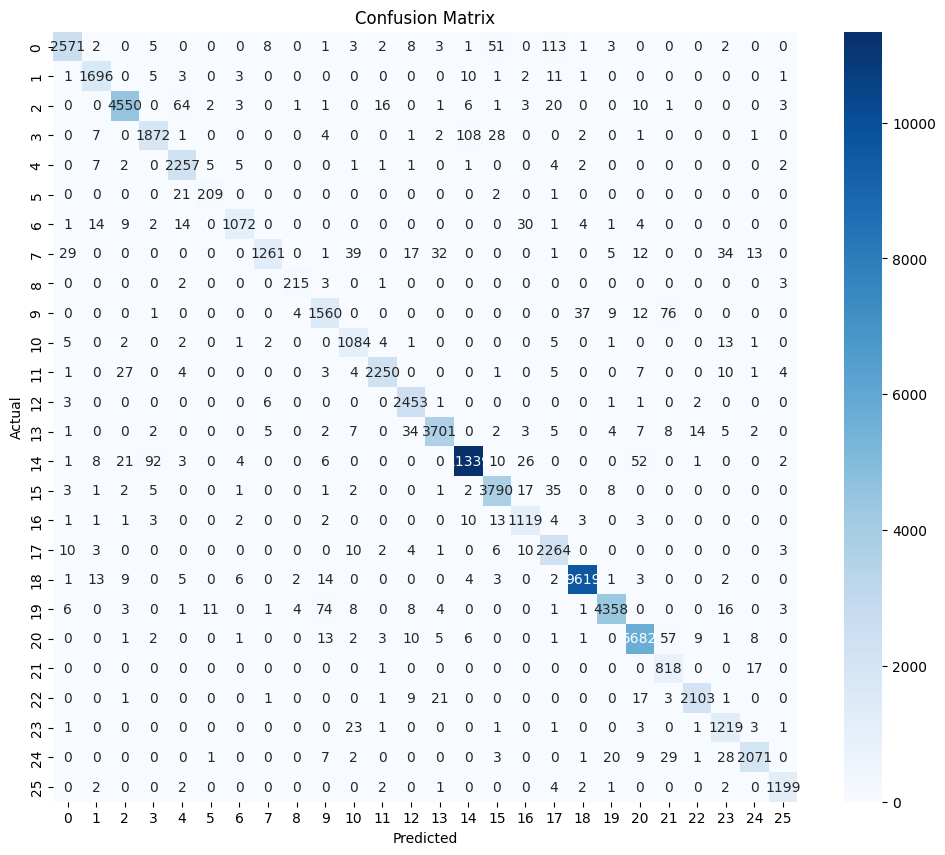

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC & AUC for multi-class

In [34]:
# Convert labels to one-hot
y_test_bin = label_binarize(y_test, classes=range(26))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

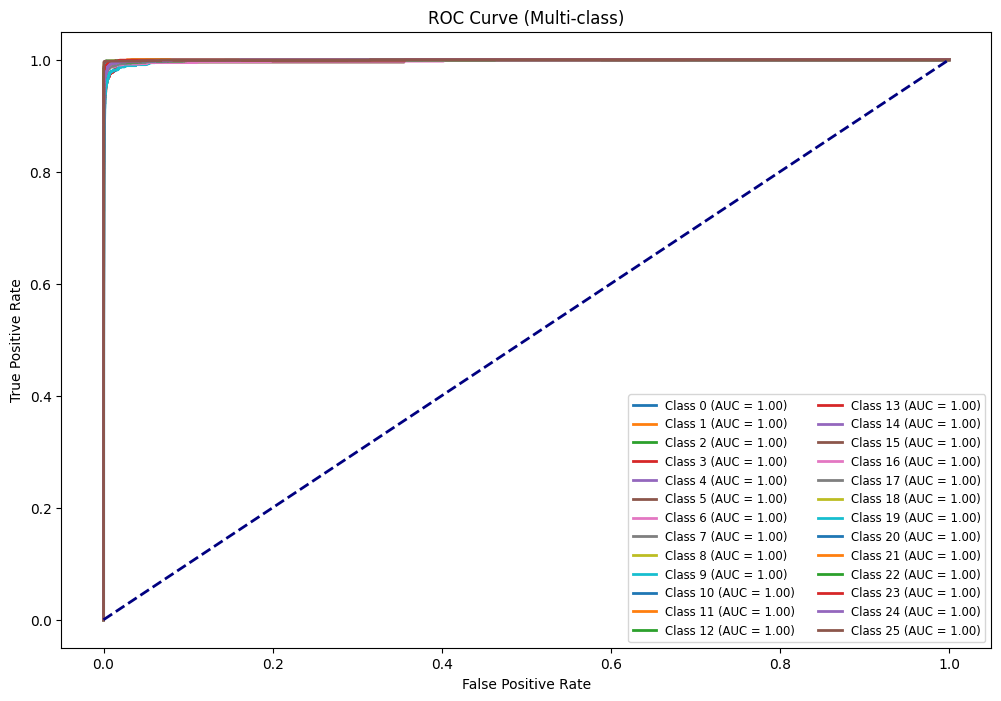

In [35]:
# Plot ROC curve for all classes
plt.figure(figsize=(12,8))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.show()